# Abrindo arquivos Grib do BAM no Python

Este notebook apresenta alguns exemplos de uso dos módulos cfgrib, pynio e py3grads para abrir os arquivos Grib do BAM. São apresentadas algumas das limitações relacionadas, bem como algumas opções para contornar parte destas limitações.

## Utilizando o Cfgrib do ECMWF

In [1]:
import xarray as xr
import cfgrib
from py3grads import Grads
import numpy as np
import matplotlib.pyplot as plt

### Abrindo um arquivo de análise pós-processada do BAM

In [2]:
ds_icn = xr.open_dataset("GPOSCPT20150523122015052312P.icn.TQ0299L064.grb", engine="cfgrib")

In [3]:
ds_icn

<xarray.Dataset>
Dimensions:            (isobaricInhPa: 33, latitude: 450, longitude: 900)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    surface            int64 ...
  * latitude           (latitude) float64 89.69 89.3 88.9 ... -88.9 -89.3 -89.69
  * longitude          (longitude) float64 0.0 0.4 0.8 1.2 ... 358.8 359.2 359.6
    valid_time         datetime64[ns] ...
  * isobaricInhPa      (isobaricInhPa) int64 1000 985 975 960 950 ... 30 20 10 3
    meanSea            int64 ...
    entireAtmosphere   int64 ...
    heightAboveGround  int64 ...
Data variables:
    topo               (latitude, longitude) float32 ...
    lsmk               (latitude, longitude) float32 ...
    pslc               (latitude, longitude) float32 ...
    uves               (latitude, longitude) float32 ...
    uvel               (isobaricInhPa, latitude, longitude) float32 ...
    vves               (latitude, longitude) float32 ...
    vvel             

### Abrindo um arquivo de previsões pós-processadas do BAM

In [4]:
ds_fct = xr.open_dataset("GPOSCPT20150530122015060106P.fct.TQ0299L064.grb", engine="cfgrib")

DatasetBuildError: multiple values for unique key, try re-open the file with one of:
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'meanSea'}
    filter_by_keys={'typeOfLevel': 'entireAtmosphere'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
    filter_by_keys={'typeOfLevel': 'cloudTop'}
    filter_by_keys={'typeOfLevel': 'nominalTop'}

O erro acima deve-se a uma falha na interpretação de algumas variáveis que constam na tabela Grib do CPTEC, mas que não constam na tabela Grib utilizada pelo ECMWF. É possível contornar este problema de duas formas:

* Utilizando um dicionário com uma lista de filtros (dados pela palavra chave 'filter_by_key');
* Utilizando explicitamente o 'cfgrib' para fazer a filtragem automática.

Entre estas duas opções, a segunda parece ser melhor, pois o resultados será uma lista de datasets. Com a primeira opções, deve-se ter certeza de quais filtros utilizar. Em nenhum dos casos, é garantida a leitura correta de todos os campos.

### Abrindo um arquivo de previsões pós-processadas do BAM utilizando uma lista de filtros

In [5]:
ds_fct1 = xr.open_dataset("GPOSCPT20150530122015060106P.fct.TQ0299L064.grb", engine="cfgrib", backend_kwargs={"filter_by_keys": {"typeOfLevel": "surface"}})

In [6]:
ds_fct1

<xarray.Dataset>
Dimensions:     (latitude: 450, longitude: 900)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     int64 ...
  * latitude    (latitude) float64 89.69 89.3 88.9 88.5 ... -88.9 -89.3 -89.69
  * longitude   (longitude) float64 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
    valid_time  datetime64[ns] ...
Data variables:
    topo        (latitude, longitude) float32 ...
    lsmk        (latitude, longitude) float32 ...
    pslc        (latitude, longitude) float32 ...
    uves        (latitude, longitude) float32 ...
    vves        (latitude, longitude) float32 ...
    tems        (latitude, longitude) float32 ...
    umrs        (latitude, longitude) float32 ...
    tsfc        (latitude, longitude) float32 ...
    tmmt        (latitude, longitude) float32 ...
    prec        (latitude, longitude) float32 ...
    prcv        (latitude, longitude) float32 ...
    cssf        (latitude, longitude) float32 ...
    clsf       

No exemplo acima, o arquivo de previsões foi aberto, mas foram filtradas quase a metade das variáveis (total: 52), e ainda uma das variáveis não foi nomeada corretamente (veja a variável "unknown").

### Abrindo um arquivo de previsões pós-processadas do BAM utilizando o cfgrib explicitamente

In [7]:
ds_fct2 = cfgrib.open_datasets("GPOSCPT20130121002013012300P.fct.TQ0062L028.grb")

Ignoring index file 'GPOSCPT20130121002013012300P.fct.TQ0062L028.grb.011ab.idx' incompatible with GRIB file


In [8]:
ds_fct2

[<xarray.Dataset>
 Dimensions:     (latitude: 96, longitude: 192)
 Coordinates:
     time        datetime64[ns] 2013-01-21
     step        timedelta64[ns] 2 days
     cloudTop    int64 0
   * latitude    (latitude) float64 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
   * longitude   (longitude) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
     valid_time  datetime64[ns] ...
 Data variables:
     cbnv        (latitude, longitude) float32 ...
 Attributes:
     GRIB_edition:            1
     GRIB_centre:             sbsj
     GRIB_centreDescription:  Brasilian Space Agency - INPE
     GRIB_subCentre:          0
     Conventions:             CF-1.7
     institution:             Brasilian Space Agency - INPE, <xarray.Dataset>
 Dimensions:           (latitude: 96, longitude: 192)
 Coordinates:
     time              datetime64[ns] 2013-01-21
     step              timedelta64[ns] 2 days
     entireAtmosphere  int64 0
   * latitude          (latitude) float64 88.57 86.72 84.86 ... -86.

No caso acima, um novo arquivo de índice é escrito no disco, semelhante ao que ocorre quando se utiliza o programa cdo (eg., "cdo gradsdes arquivo.grib") em que ambos os arquivos "ctl" e "idx" são criados a partir do arquivo Grib. Uma outra forma é a partir do script "grib2ctl".

Como resultado, uma lista de 10 datasets é retornada no objeto "ds_fct2":

In [9]:
type(ds_fct2)

list

In [10]:
len(ds_fct2)

10

In [11]:
ds_fct2

[<xarray.Dataset>
 Dimensions:     (latitude: 96, longitude: 192)
 Coordinates:
     time        datetime64[ns] 2013-01-21
     step        timedelta64[ns] 2 days
     cloudTop    int64 0
   * latitude    (latitude) float64 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
   * longitude   (longitude) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
     valid_time  datetime64[ns] ...
 Data variables:
     cbnv        (latitude, longitude) float32 ...
 Attributes:
     GRIB_edition:            1
     GRIB_centre:             sbsj
     GRIB_centreDescription:  Brasilian Space Agency - INPE
     GRIB_subCentre:          0
     Conventions:             CF-1.7
     institution:             Brasilian Space Agency - INPE, <xarray.Dataset>
 Dimensions:           (latitude: 96, longitude: 192)
 Coordinates:
     time              datetime64[ns] 2013-01-21
     step              timedelta64[ns] 2 days
     entireAtmosphere  int64 0
   * latitude          (latitude) float64 88.57 86.72 84.86 ... -86.

In [12]:
ds_fct2[-1].prec

<xarray.DataArray 'prec' (latitude: 96, longitude: 192)>
array([[0.167969, 0.166016, 0.166016, ..., 0.152344, 0.158203, 0.162109],
       [0.185547, 0.195312, 0.207031, ..., 0.169922, 0.175781, 0.181641],
       [0.173828, 0.189453, 0.205078, ..., 0.154297, 0.160156, 0.167969],
       ...,
       [0.009766, 0.009766, 0.011719, ..., 0.007812, 0.007812, 0.009766],
       [0.017578, 0.017578, 0.017578, ..., 0.015625, 0.015625, 0.015625],
       [0.105469, 0.105469, 0.103516, ..., 0.113281, 0.111328, 0.109375]],
      dtype=float32)
Coordinates:
    time        datetime64[ns] 2013-01-21
    step        timedelta64[ns] 2 days
    surface     int64 0
  * latitude    (latitude) float64 88.57 86.72 84.86 ... -84.86 -86.72 -88.57
  * longitude   (longitude) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
    valid_time  datetime64[ns] 2013-01-23
Attributes:
    GRIB_paramId:                             300061
    GRIB_shortName:                           prec
    GRIB_units:                 

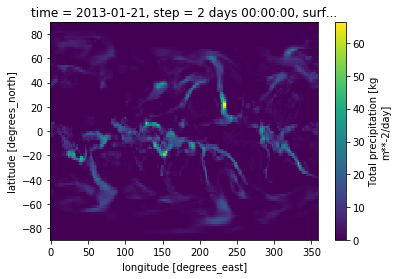

In [13]:
ds_fct2[-1].prec.plot()

# Utilizando o PyNIO do NCAR

Semelhante ao Cfgrib que abre um arquivo Grib e utiliza o xarray para criar uma estrutura de dados adequada, pode-se utilizar também o PyNIO como engine de leitura.

## Abrindo um arquivo de análise pós-processada do BAM

In [14]:
ds_icn2 = xr.open_dataset("GPOSCPT20150523122015052312P.icn.TQ0299L064.grb", engine="pynio")

In [15]:
ds_icn2

<xarray.Dataset>
Dimensions:         (g4_lat_0: 450, g4_lon_1: 900, lv_ISBL2: 33)
Coordinates:
  * lv_ISBL2        (lv_ISBL2) int32 3 10 20 30 50 70 ... 950 960 975 985 1000
  * g4_lat_0        (g4_lat_0) float32 89.694145 89.29794 ... -89.694145
  * g4_lon_1        (g4_lon_1) float32 0.0 0.4 0.8 1.2 ... 358.8 359.2 359.6
Data variables:
    PSNM_GDS4_MSL   (g4_lat_0, g4_lon_1) float32 ...
    ZGEO_GDS4_ISBL  (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    TEMP_GDS4_ISBL  (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    UVEL_GDS4_ISBL  (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    VVEL_GDS4_ISBL  (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    FCOR_GDS4_ISBL  (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    POTV_GDS4_ISBL  (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    OMEG_GDS4_ISBL  (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    VORT_GDS4_ISBL  (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    UMES_GDS4_ISBL  (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    UMRL_GDS4_ISBL  (lv_ISBL2, g4_lat_0,

Observe que, diferentemente do Cfgrib, o PyNIO renomeia as variáveis.

## Abrindo um arquivo de previsões pós-processadas do BAM

In [16]:
ds_fct3 = xr.open_dataset("GPOSCPT20150530122015060106P.fct.TQ0299L064.grb", engine="pynio")

In [17]:
ds_fct3

<xarray.Dataset>
Dimensions:              (g4_lat_0: 450, g4_lon_1: 900, lv_ISBL2: 33)
Coordinates:
  * lv_ISBL2             (lv_ISBL2) int32 3 10 20 30 50 ... 950 960 975 985 1000
  * g4_lat_0             (g4_lat_0) float32 89.694145 89.29794 ... -89.694145
  * g4_lon_1             (g4_lon_1) float32 0.0 0.4 0.8 ... 358.8 359.2 359.6
Data variables:
    PSNM_GDS4_MSL        (g4_lat_0, g4_lon_1) float32 ...
    ZGEO_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    VAR_10_GDS4_SFC      (g4_lat_0, g4_lon_1) float32 ...
    TEMP_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    TPOR_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    UVEL_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    VVEL_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    FCOR_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    POTV_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    OMEG_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1)

In [18]:
len(ds_fct3.variables)

55

In [19]:
ds_fct3.data_vars

Data variables:
    PSNM_GDS4_MSL        (g4_lat_0, g4_lon_1) float32 ...
    ZGEO_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    VAR_10_GDS4_SFC      (g4_lat_0, g4_lon_1) float32 ...
    TEMP_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    TPOR_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    UVEL_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    VVEL_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    FCOR_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    POTV_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    OMEG_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    VORT_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    UMES_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    UMRL_GDS4_ISBL       (lv_ISBL2, g4_lat_0, g4_lon_1) float32 ...
    AGPL_GDS4_EATM       (g4_lat_0, g4_lon_1) float32 ...
    PREC_GDS4_SFC_acc3h  (g4_lat_0, g4_lon_1) float32 ...
    

In [20]:
ds_fct3.PREC_GDS4_SFC_acc3h

<xarray.DataArray 'PREC_GDS4_SFC_acc3h' (g4_lat_0: 450, g4_lon_1: 900)>
[405000 values with dtype=float32]
Coordinates:
  * g4_lat_0  (g4_lat_0) float32 89.694145 89.29794 ... -89.29794 -89.694145
  * g4_lon_1  (g4_lon_1) float32 0.0 0.4 0.8 1.2 1.6 ... 358.4 358.8 359.2 359.6
Attributes:
    center:                   Brasilian Space Agency - INPE
    long_name:                TOTAL PRECIPITATION
    units:                    Kg/m2/day
    level_indicator:          [1]
    gds_grid_type:            [4]
    parameter_table_version:  [254]
    parameter_number:         [61]
    forecast_time:            [14]
    forecast_time_units:      3 hours
    initial_time:             05/30/2015 (12:00)

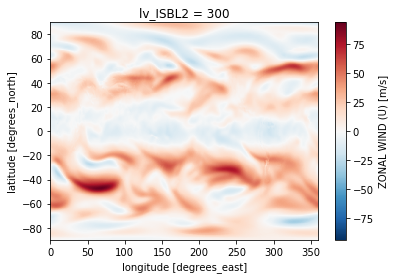

In [21]:
ds_fct3.UVEL_GDS4_ISBL.isel(lv_ISBL2=10).plot()

## Abrindo um arquivo de análise pós-processada do BAM

Abaixo, foi escrita uma função "genérica" para utilizar o py3grads para abrir um arquivo "ctl" e devolver um xarray com os atributos das variáveis. Esta é a pior solução entre as três opções, pois é lenta, depende de uma instalação local do Grads e não é otimizada para ler muitos arquivos (é melhor usar o próprio Grads mesmo):

In [22]:
ga = Grads(verbose=False)

In [23]:
def open_bam_ctl(filein):

    """
    Função: open_bam_ctl
    Uso: f = open_bam_ctl("arquivo.ctl")
    """

    f = ga("open " + str(filein))

    finfo = ga("q file")

    f_descriptor = finfo[0][1]
    f_binary     = finfo[0][2]
    f_type       = finfo[0][3]
    f_dims       = finfo[0][4]
    f_nvars      = finfo[0][5]
    f_vlist      = finfo[0][6:]

#    f_dict = {
#            "descriptor": f_descriptor,
#            "binary"    : f_binary,
#            "type"      : f_type, 
#            "dims"      : f_dims,
#            "nvars"     : f_nvars,
#            "vlist"     : f_vlist,
#             }

    v_list = []
    for var in f_vlist[0:-1]:
        nvar = var.strip().split()[0]

        nlevs = var.strip().split()[1]
        if int(nlevs) == 0:
            nlevs = 1

        ga(f"set z 1 {nlevs}")

        data = ga.exp(nvar)
        menv = ga.env()
        ipts = menv.nx
        jpts = menv.ny
        ilon = menv.lon[0]
        flon = menv.lon[1]
        ilat = menv.lat[0]
        flat = menv.lat[1]
        lons = np.linspace(ilon,flon,ipts)
        lats = np.linspace(ilat,flat,jpts)
#        a_lons = ga.exp("lon")
#        lons = a_lons[:][0]
#
#        a_levs = ga.exp("lev")
#        levs = a_levs[0][0]
#
#        a_lats = ga.exp("lat")


        time = menv.time

        if int(nlevs) > 1:
            levs = np.arange(1,int(nlevs)+1)
            coords_dict = {"lat": lats, "lon": lons, "lev": levs, "date": time}
            dims_list = ["lat", "lon", "lev"]
        else:
            coords_dict = {"lat": lats, "lon": lons, "date": time}
            dims_list = ["lat", "lon"]

        # Cria um DataArray
        da_moddata = xr.DataArray(data, name=str(nvar), coords=coords_dict, dims=dims_list)

        var_name_str = var.strip().split()

        # Remove o último elemento se ele for um ")"
        if str(")") in var_name_str:
            var_name_str.remove(")")

        # Verifica se o quinto elemento é o nome da variável (em uppercase):
        # - Se não for, acrescenta um elemento (espaço em branco)
        if var_name_str[4].isupper():
            var_name_str.insert(4, " ")

        # O nome da variável será composto a partir do sexto elemento:
        var_name_substr = var_name_str[5:]
        long_name = " ".join(var_name_substr[:-1])
        units = var_name_substr[-1].replace("(","")

        da_moddata.attrs["Long Name"] = str(long_name)
        da_moddata.attrs["Units"] = str(units)

        print(long_name,units)

        v_list.append(da_moddata)

    # Cria um Dataset a partir da combinação dos DataArrays
    da_lstdata = xr.merge(v_list)

    # Escreve o Dataset em um arquivo NetCDF
    tmp_name = f_binary.replace("  Binary: ","")
    out_name = tmp_name.replace(".grb",".nc")

    da_lstdata.to_netcdf(str(out_name))
    # Fecha o arquivo ctl
    ga("close 1")

    return da_lstdata, menv

In [24]:
ds_icn3 = open_bam_ctl("GPOSCPT20150523122015052312P.icn.TQ0299L064.ctl")

TOPOGRAPHY [m]
LAND SEA MASK [0,1]
SURFACE PRESSURE HPA
SURFACE ZONAL WIND (U) M/S
ZONAL WIND (U) M/S
SURFACE MERIDIONAL WIND (V) M/S
MERIDIONAL WIND (V) M/S
OMEGA PA/S
VORTICITY 1/S
STREAM FUNCTION M2/S
VELOCITY POTENTIAL M2/S
GEOPOTENTIAL HEIGHT GPM
SEA LEVEL PRESSURE HPA
SURFACE ABSOLUTE TEMPERATURE K
ABSOLUTE TEMPERATURE K
SURFACE RELATIVE HUMIDITY (NO DIM
RELATIVE HUMIDITY (NO DIM
SPECIFIC HUMIDITY KG/KG
INST. PRECIPITABLE WATER KG/M2
SURFACE TEMPERATURE K
PARTIAL OXYGEN DENSITY g/m**3


In [25]:
ds_icn3

(<xarray.Dataset>
 Dimensions:  (lat: 450, lev: 33, lon: 901)
 Coordinates:
   * lat      (lat) float64 -89.69 -89.29 -88.9 -88.5 ... 88.5 88.9 89.29 89.69
   * lon      (lon) float64 0.0 0.4 0.8 1.2 1.6 ... 358.4 358.8 359.2 359.6 360.0
     date     datetime64[ns] 2015-05-23T12:00:00
   * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 ... 24 25 26 27 28 29 30 31 32 33
 Data variables:
     topo     (lat, lon) float32 2768.5256 2768.9006 ... -0.97431946 -0.97431946
     lsmk     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0 2.0
     pslc     (lat, lon) float32 688.3203 688.27344 ... 1006.64844 1006.64844
     uves     (lat, lon) float32 -6.4793854 -6.4227448 ... -6.3543854 -6.3875885
     uvel     (lat, lon, lev) float64 -6.479 -6.479 -6.479 ... -0.4139 -11.08
     vves     (lat, lon) float32 -9.120575 -9.165497 ... -3.0170593 -2.9721375
     vvel     (lat, lon, lev) float64 -9.121 -9.121 -9.12 ... 3.55 4.312 -1.914
     omeg     (lat, lon, lev) float64 0.0049 0.0049 ... -

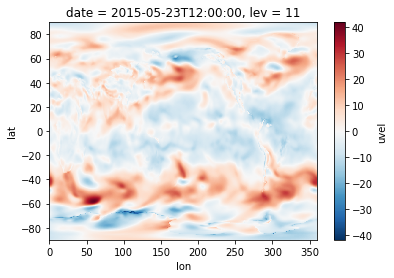

In [26]:
ds_icn3[0].uvel.isel(lev=10).plot()

## Abrindo um arquivo de previsões pós-processadas do BAM

In [27]:
ds_fct4 = open_bam_ctl("GPOSCPT20150530122015060106P.fct.TQ0299L064.ctl")

TOPOGRAPHY [m]
LAND SEA MASK [0,1]
SURFACE PRESSURE HPA
SURFACE ZONAL WIND (U) M/S
ZONAL WIND (U) M/S
SURFACE MERIDIONAL WIND (V) M/S
MERIDIONAL WIND (V) M/S
OMEGA PA/S
VORTICITY 1/S
STREAM FUNCTION M2/S
VELOCITY POTENTIAL M2/S
GEOPOTENTIAL HEIGHT GPM
SEA LEVEL PRESSURE HPA
SURFACE ABSOLUTE TEMPERATURE K
ABSOLUTE TEMPERATURE K
SURFACE RELATIVE HUMIDITY (NO DIM
RELATIVE HUMIDITY (NO DIM
SPECIFIC HUMIDITY KG/KG
INST. PRECIPITABLE WATER KG/M2
SURFACE TEMPERATURE K
PARTIAL OXYGEN DENSITY g/m**3
TIME MEAN SURFACE TEMPERATURE K
TOTAL PRECIPITATION KG/M2/DAY
CONVECTIVE PRECIPITATION KG/M2/DAY
SENSIBLE HEAT FLUX FROM SURFACE W/M2
LATENT HEAT FLUX FROM SURFACE W/M2
SURFACE ZONAL WIND STRESS PA
SURFACE MERIDIONAL WIND STRESS PA
CLOUD COVER 0-1
DOWNWARD LONG WAVE AT BOTTOM W/M2
UPWARD LONG WAVE AT BOTTOM W/M2
OUTGOING LONG WAVE AT TOP W/M2
DOWNWARD SHORT WAVE AT GROUND W/M2
UPWARD SHORT WAVE AT GROUND W/M2
UPWARD SHORT WAVE AT TOP W/M2
SHORT WAVE ABSORBED AT GROUND W/M2
GROUND/SURFACE COVER TEMPE

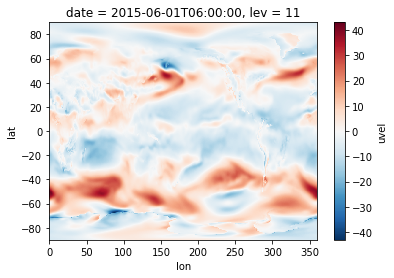

In [28]:
ds_fct4[0].uvel.isel(lev=10).plot()